In [1]:
import numpy as np
from scipy.special import airy
import optuna

import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 2

from ComptonSpec_classic import Trajectory, Spectrum
from utils_simulation import *
from utils_analytics import *

In [2]:
def calc_A_quadratic(x, tau=2*np.pi, a0=1, beta1=0, beta2=0):
    '''
    Calculate laser vector potential for laser pulse with quadratic spectral chirp
    '''
    prefactor = np.sqrt(2*np.pi)*a0*tau*(2/beta2)**(1/3)
    z = (0.5*(beta1**2 + 2*1j*beta1 - 1)*tau**4/beta2 + x)*(2/beta2)**(1/3)
    exp_pref = np.exp(-(tau**3/beta2)**2/3*(3*beta1**2 - 1) - tau**2/beta2*x)
    exp_phase = np.exp(1j*tau**6/(3*beta2**3)*(beta1**3 - 3*beta1)) * np.exp(1j*beta1*tau**2/beta2*x)
    A = prefactor * airy(-z)[0] * exp_pref * exp_phase * np.exp(-1j*x)
    Ax, Ay = np.real(A), np.imag(A)
    
    return np.array([Ax, Ay])

def A_spectral(w, a0, tau, beta1=0, beta2=0, beta3=0):
    env = np.exp(-0.5*tau**2*w**2)
    phase = np.exp(1j*0.5*beta1*tau**2*w**2 + 1j*beta2*tau**3/6*w**3 + 1j*beta3*tau**4/24*w**4)
    # return env * phase
    return np.sqrt(2*np.pi) * a0 * tau * env * phase

def ft(samples, Fs, t0):
    """Approximate the Fourier Transform of a time-limited
    signal by means of the discrete Fourier Transform.

    samples: signal values sampled at the positions t0 + n/Fs
    Fs: Sampling frequency of the signal
    t0: starting time of the sampling of the signal
    """
    f = np.linspace(-Fs/2, Fs/2, len(samples), endpoint=False)
    return np.fft.fftshift(np.fft.fft(samples)/Fs * np.exp(2j*np.pi*f*t0))
    
def ift(samples, Fs, t0):
    f = np.linspace(-Fs/2, Fs/2, len(samples), endpoint=False)
    return np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(samples), norm='forward')/Fs * np.exp(-2j*np.pi*f*t0))
    
def pad_with_zeros(samples, n_padded):
        n_points = len(samples)
        # Padding with zeros to the nearest power of 2
        n_padded = n_points * n_padded
        n_samples = n_points + 2*n_padded
        n_samples = 2**(int(np.log2(n_samples)))
        n_padded = (n_samples - n_points) // 2

        samples_padded = np.pad(samples, n_padded, 'constant')
        return samples_padded
    
def Aw_2_Aphi(w, a0, tau, beta1, beta2, beta3=0, padded=True, n_padded=12):
    wb, dw = w[-1], w[1] - w[0]
    nw = w.shape[0]
    A_w = A_spectral(w, a0, tau, beta1, beta2, beta3)
    
    if padded:
        A_w = pad_with_zeros(A_w, n_padded)
        wb = wb + (len(A_w) - nw)//2*dw
        w = np.linspace(-wb, wb, int(2*wb_new/dw))
    
    A_phi = ft(A_w, 1/dw, wb) / (2*np.pi)
    phi = np.linspace(-0.5/dw, 0.5/dw, len(A_w), endpoint=False) * 2 * np.pi
    A_phi *= np.exp(-1j*phi)*(-1)
    A_phi[:len(A_phi)//2] *= -1
    
    return phi, [np.real(A_phi), np.imag(A_phi)]

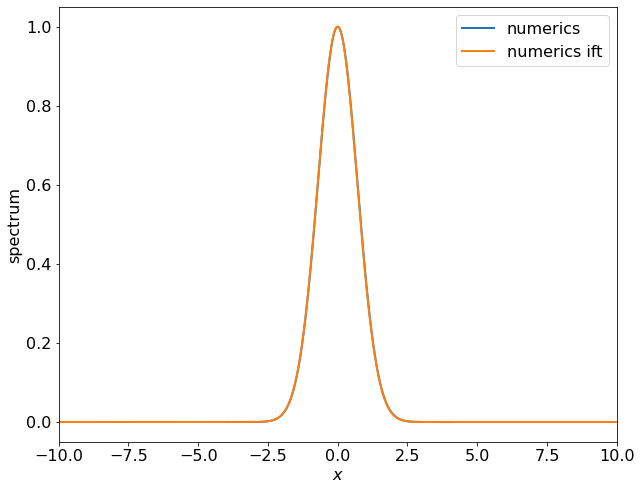

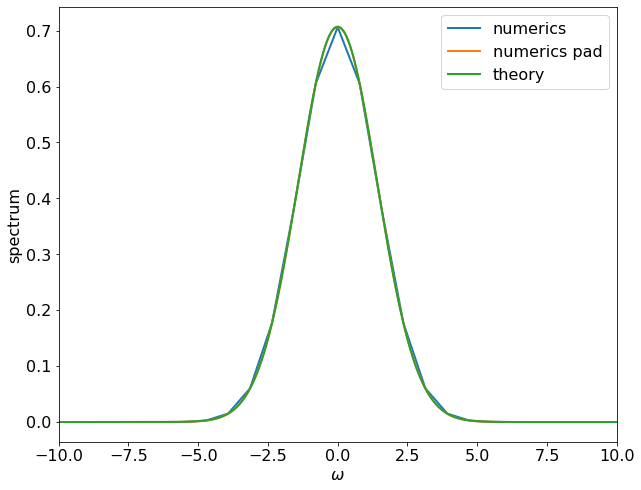

In [175]:
# Check the DFT analog to continuous Fourier transform

def f(x, alpha=1):
    return np.exp(-alpha*x**2)

def f_w(w, alpha=1):
    return 1/np.sqrt(2*alpha) * np.exp(-w**2/(4*alpha))

# define params
alpha = 1
xb = 4/np.sqrt(alpha)
n_x = 100
dx = 1 / n_x
n_padded = 12

# pad input
x = np.linspace(-xb, xb, int(2*xb/dx))
fx = f(x, alpha)
fx_padded = pad_with_zeros(fx, n_padded)
xb_padded = xb + (len(fx_padded) - len(fx))//2*dx

# calculate unpadded and padded FT
f_w_comp = ft(fx, 1/dx, xb) / np.sqrt(2*np.pi)
w_comp = 2*np.pi*np.linspace(-0.5/dx, 0.5/dx, len(fx), endpoint=False)

f_w_comp_pad = ft(fx_padded, 1/dx, xb_padded) / np.sqrt(2*np.pi)
w_comp_pad = 2*np.pi*np.linspace(-0.5/dx, 0.5/dx, len(fx_padded), endpoint=False)

# calculate inverse FT
dw = w_comp_pad[1] - w_comp_pad[0]
wb = w_comp_pad[-1]
fx_comp = ift(f_w_comp_pad, 1/dw, wb) / np.sqrt(2*np.pi)
x_comp = 2*np.pi*np.linspace(-0.5/dw, 0.5/dw, len(f_w_comp_pad), endpoint=False)

# calculate analytic 
w = np.linspace(-10,10, 2*10*100)
f_w_th = f_w(w, alpha)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x, fx, label='numerics')
plt.plot(x_comp, np.abs(fx_comp), label='numerics ift')
ax.set_xlim([-10,10])
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('spectrum')
plt.show()


fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_comp, np.abs(f_w_comp), label='numerics')
plt.plot(w_comp_pad, np.abs(f_w_comp_pad), label='numerics pad')
plt.plot(w, f_w_th, label='theory')
ax.set_xlim([-10,10])
plt.legend(loc='best')
plt.xlabel('$\omega$')
plt.ylabel('spectrum')
plt.show()

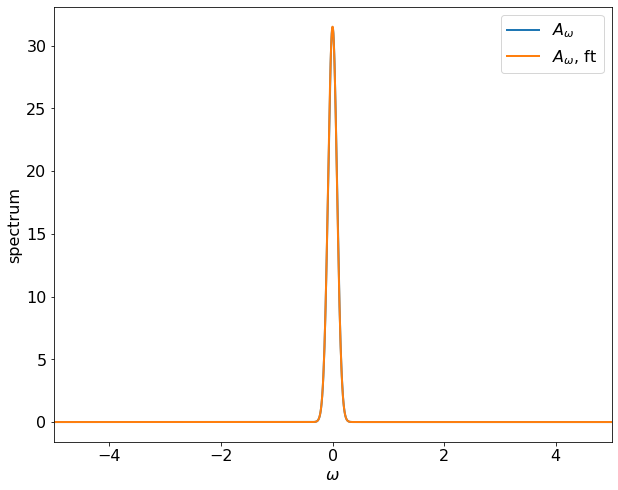

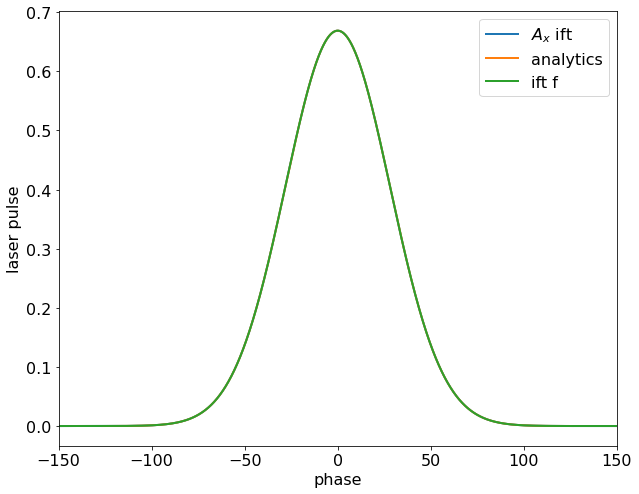

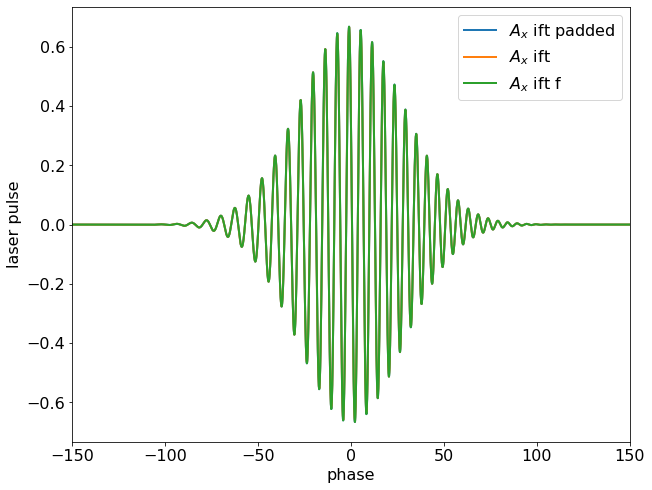

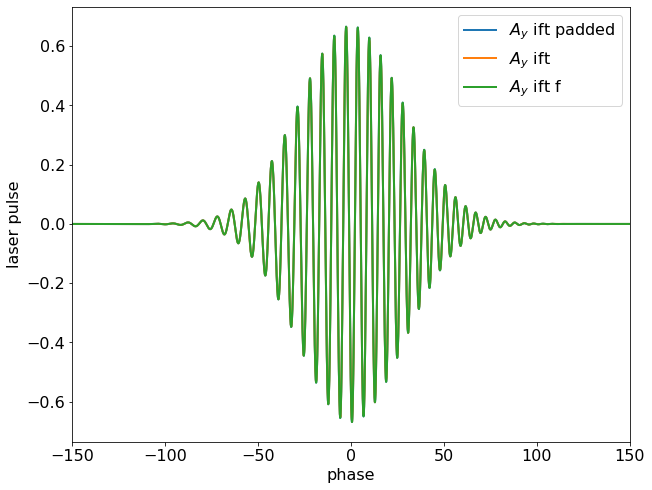

In [176]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

tau = 4 * np.pi    # Pulse duration
a0 = 1             # Pulse amplitude
mode = 'gauss_spectral'   # Temporal envelope
beta1 = 2            # Linear chirp parameter
beta2 = 0  
wb = 10
n_w = 100
n_padded = 12

# calculate A in the time domain
eta_b = 4.5*tau*np.sqrt(1+beta1**2)
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta, mode, tau, a0, beta1)
d_eta = eta[1] - eta[0]
A_padded = pad_with_zeros((A[0] - 1j*A[1])*np.exp(1j*eta), n_padded)
eta_b_new = eta_b + (len(A_padded)-len(A))//2*d_eta

A_w_comp = ift(A_padded, 1/d_eta, eta_b_new)
w_comp = np.linspace(-0.5/d_eta, 0.5/d_eta, len(A_padded), endpoint=False) * 2 * np.pi


# calculate A in the spectral domain
w_arr = np.linspace(-wb, wb, int(2*wb*n_w))
dw = w_arr[1] - w_arr[0]
A_w = A_spectral(w_arr, a0, tau, beta1, beta2)

A_w_padded = pad_with_zeros(A_w, n_padded)
wb_new = wb + (len(A_w_padded)-len(A_w))//2*dw
w_arr_padded = np.linspace(-wb_new, wb_new, int(2*wb_new*n_w))

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_arr, np.abs(A_w), label='$A_\omega$')
plt.plot(w_comp, np.abs(A_w_comp), label='$A_\omega$, ft')
ax.set_xlim([-5,5])
plt.legend(loc='best')
plt.xlabel('$\omega$')
plt.ylabel('spectrum')
plt.show()


n_w0 = len(w_arr)
dw = w_arr[1] - w_arr[0]

A_phi = ft(A_w, 1/dw, wb) / (2*np.pi)
phi = np.linspace(-0.5/dw, 0.5/dw, len(A_w), endpoint=False) * 2 * np.pi
A_phi *= np.exp(-1j*phi)*(-1)
A_phi[:len(A_phi)//2] *= -1

A_phi_padded = ft(A_w_padded, 1/dw, wb_new) / (2*np.pi)
phi_padded = np.linspace(-0.5/dw, 0.5/dw, len(A_w_padded), endpoint=False) * 2 * np.pi
A_phi_padded *= np.exp(-1j*phi_padded)*(-1)
A_phi_padded[:len(A_phi_padded)//2] *= -1

phi_f, A_phi_f = Aw_2_Aphi(w_arr, a0, tau, beta1, beta2)


b = 150
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(phi, np.abs(A_phi), label='$A_x$ ift')
plt.plot(eta, np.sqrt(A[0]**2+A[1]**2), label='analytics')
plt.plot(phi_f, np.sqrt(A_phi_f[0]**2+A_phi_f[1]**2), label='ift f')
ax.set_xlim([-b,b])
plt.legend(loc='best')
plt.xlabel('phase')
plt.ylabel('laser pulse')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(phi_padded, np.real(A_phi_padded), label='$A_x$ ift padded')
plt.plot(phi, np.real(A_phi), label='$A_x$ ift')
plt.plot(phi_f, A_phi_f[0], label='$A_x$ ift f')
# plt.plot(eta, A[0], label='analytics')
ax.set_xlim([-b,b])
plt.legend(loc='best')
plt.xlabel('phase')
plt.ylabel('laser pulse')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(phi_padded, np.imag(A_phi_padded), label='$A_y$ ift padded')
plt.plot(phi, np.imag(A_phi), label='$A_y$ ift')
plt.plot(phi_f, A_phi_f[1], label='$A_y$ ift f')
# plt.plot(eta, -A[1], label='analytics')
ax.set_xlim([-b,b])
plt.legend(loc='best')
plt.xlabel('phase')
plt.ylabel('laser pulse')
plt.show()

In [224]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

tau = 4 * np.pi    # Pulse duration
a0 = 1             # Pulse amplitude
mode = 'gauss_spectral'   # Temporal envelope
beta1 = 3            # Linear chirp parameter
beta2 = -1            # Quadratic chirp parameter
beta3 = 2          # Cubic chirp parameter
polarization = 'circular'

# Calculate spectra for non-chirped laser pulse
# beta1, beta2 = 15., -1* tau**3
# eta_b = 8*tau*np.sqrt(1+beta1**2)
# eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
# A = calc_A(eta, mode, tau, a0, beta1)
# A_new = calc_A_quadratic(eta, tau, a0, beta1, beta2)
w0 = 10
w = np.linspace(-w0, w0, int(2*w0*200))
eta, A = Aw_2_Aphi(w, a0, tau, beta1, beta2, padded=True)

u, r = traj.calc_u_x(A, eta)

# Calculate spectrum
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi, n_t=50)

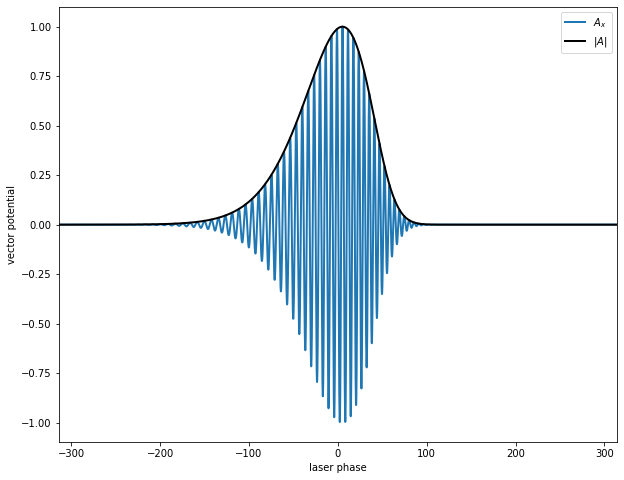

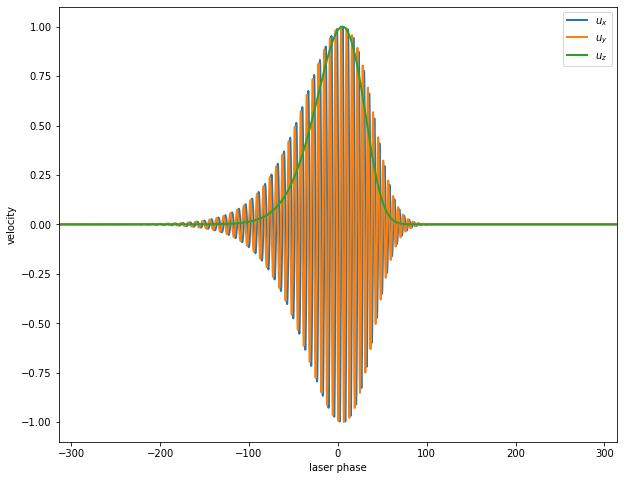

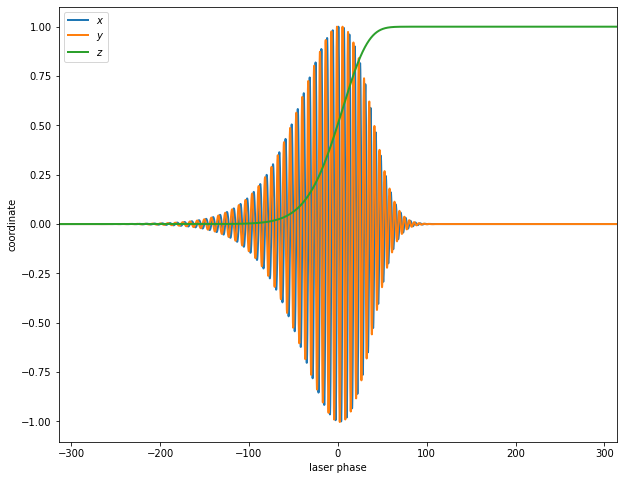

In [229]:
A_mod = np.sqrt(A[0]**2 + A[1]**2)
x0 = eta[-1]//2

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, A[0]/np.max(A[0]), label='$A_x$')
# plt.plot(eta, A_new[1]/np.max(A_new[1]), label='$A_y$')
plt.plot(eta, A_mod/np.max(A_mod), label='$|A|$', color='black')
ax.set_xlim([-x0, x0])
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('vector potential')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
ax.set_xlim([-x0, x0])
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
ax.set_xlim([-x0, x0])
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

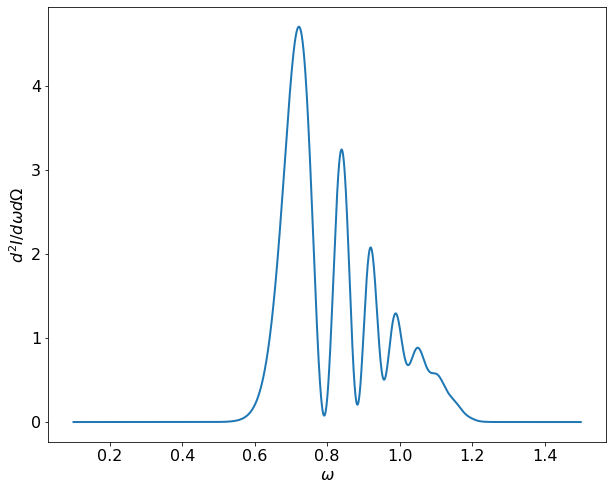

In [190]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_plot, I_plot, label='numerical')
plt.xlabel('$\omega$')
plt.ylabel('$d^2 I / d\omega d\Omega$')
plt.show()

## Optuna for quadratic

In [3]:
tau = 2 * np.pi    # Pulse duration
a0 = 2
wb = [0., 1.5]

def objective_lin(trial):
    # Define range over chirp values
    beta = trial.suggest_float("beta", 0, 25)
    # Calculate spectrun for chosen beta value
    eta_b = 4.4*tau*np.sqrt(1+beta**2)
    eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
    # Calculate laser pulse vector potential and electron trajectory
    A = calc_A(eta, mode, tau=tau, a0=a0, beta=beta, polarization=polarization)
    u, r = traj.calc_u_x(A, eta)
    # Calculate Compton spectra
    spec = Spectrum(eta, u, r)
    I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)
    idx = (w > 0)
    # Transform d2 I/dw dOmega -> d2 N_ph / dw dOmega
    N_ph = I[idx] / w[idx] / 137
    w = w[idx]
    idx = (w >= wb[0]) & (w <= wb[1])
    return np.max(N_ph[idx])

def objective_quad(trial):
    # Define range over chirp values
    beta1 = trial.suggest_float("beta1", 0, 35)
    beta2 = trial.suggest_float("beta2", -25, 2)

    w0 = 10
    w = np.linspace(-w0, w0, int(2*w0*200))
    # Calculate vector potential
    eta, A = Aw_2_Aphi(w, a0, tau, beta1, beta2, padded=True)
    # Calculate trajectories
    u, r = traj.calc_u_x(A, eta)
    # Calculate Compton spectra
    spec = Spectrum(eta, u, r)
    I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)
    idx = (w > 0)
    # Transform d2 I/dw dOmega -> d2 N_ph / dw dOmega
    N_ph = I[idx] / w[idx] / 137
    w = w[idx]
    idx = (w >= wb[0]) & (w <= wb[1])
    return np.max(N_ph[idx])

def objective_cubic(trial):
    # Define range over chirp values
    beta1 = trial.suggest_float("beta1", 0, 35)
    beta2 = trial.suggest_float("beta2", -25, 15)
    beta3 = trial.suggest_float("beta3", -15, 15)

    w0 = 10
    w = np.linspace(-w0, w0, int(2*w0*200))
    # Calculate vector potential
    eta, A = Aw_2_Aphi(w, a0, tau, beta1, beta2, beta3, padded=True)
    # Calculate trajectories
    u, r = traj.calc_u_x(A, eta)
    # Calculate Compton spectra
    spec = Spectrum(eta, u, r)
    I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)
    idx = (w > 0)
    # Transform d2 I/dw dOmega -> d2 N_ph / dw dOmega
    N_ph = I[idx] / w[idx] / 137
    w = w[idx]
    idx = (w >= wb[0]) & (w <= wb[1])
    return np.max(N_ph[idx])

In [243]:
lin = study_lin.best_value
quad = study_quad.best_value
cubic = study_cubic.best_value
print(quad / lin)
print(cubic / quad)
print(cubic / lin)

2.638606926411495
1.125967616394544
2.970985951533685


In [4]:
study_name = 'chirp_lin_optimization'
storage_name = 'sqlite:///data/optuna/{}.db'.format(study_name)
study_lin = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name, load_if_exists=True)

study_name = 'chirp_quad_optimization_25'
storage_name = 'sqlite:///data/optuna/{}.db'.format(study_name)
study_quad = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name, load_if_exists=True)

study_name = 'chirp_cubic_optimization_25_15'
storage_name = 'sqlite:///data/optuna/{}.db'.format(study_name)
study_cubic = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name, load_if_exists=True)

[I 2022-05-02 18:17:14,506] Using an existing study with name 'chirp_lin_optimization' instead of creating a new one.
[I 2022-05-02 18:17:14,535] Using an existing study with name 'chirp_quad_optimization_25' instead of creating a new one.
[I 2022-05-02 18:17:14,564] Using an existing study with name 'chirp_cubic_optimization_25_15' instead of creating a new one.


In [209]:
study_lin.optimize(objective_lin, n_trials=40)

[I 2022-04-27 18:07:23,737] Trial 40 finished with value: 0.10872577112583859 and parameters: {'beta': 6.062339886304143}. Best is trial 24 with value: 0.2605193536555732.
[I 2022-04-27 18:07:24,428] Trial 41 finished with value: 0.2603885438947787 and parameters: {'beta': 12.123587317096106}. Best is trial 24 with value: 0.2605193536555732.
[I 2022-04-27 18:07:25,200] Trial 42 finished with value: 0.2478450324131312 and parameters: {'beta': 10.520558999111113}. Best is trial 24 with value: 0.2605193536555732.
[I 2022-04-27 18:07:25,983] Trial 43 finished with value: 0.25979118273518537 and parameters: {'beta': 12.883738587206574}. Best is trial 24 with value: 0.2605193536555732.
[I 2022-04-27 18:07:26,525] Trial 44 finished with value: 0.19988364843188755 and parameters: {'beta': 8.514048267450756}. Best is trial 24 with value: 0.2605193536555732.
[I 2022-04-27 18:07:27,311] Trial 45 finished with value: 0.25125470793309473 and parameters: {'beta': 14.332453027633573}. Best is trial 2

In [215]:
study_quad.optimize(objective_quad, n_trials=1000)

[I 2022-04-27 18:22:51,858] Trial 0 finished with value: 0.19521026921561635 and parameters: {'beta1': 21.74485083672346, 'beta2': -3.2120653122476277}. Best is trial 0 with value: 0.19521026921561635.
[I 2022-04-27 18:22:54,070] Trial 1 finished with value: 0.2922103433900395 and parameters: {'beta1': 14.665327409917172, 'beta2': -2.1873776826458027}. Best is trial 1 with value: 0.2922103433900395.
[I 2022-04-27 18:22:56,413] Trial 2 finished with value: 0.14906568057442632 and parameters: {'beta1': 5.807852479409832, 'beta2': -13.35966614707487}. Best is trial 1 with value: 0.2922103433900395.
[I 2022-04-27 18:22:58,691] Trial 3 finished with value: 0.18641596752081283 and parameters: {'beta1': 10.683472843448765, 'beta2': -19.480737165606463}. Best is trial 1 with value: 0.2922103433900395.
[I 2022-04-27 18:23:00,925] Trial 4 finished with value: 0.16462123018490651 and parameters: {'beta1': 8.11904154151573, 'beta2': -23.858670035008004}. Best is trial 1 with value: 0.2922103433900

In [236]:
study_cubic.optimize(objective_cubic, n_trials=2000)

[I 2022-04-27 19:56:06,877] Trial 0 finished with value: 0.16116977606518446 and parameters: {'beta1': 9.265012897965494, 'beta2': -21.31455946531218, 'beta3': -8.720470448707403}. Best is trial 0 with value: 0.16116977606518446.
[I 2022-04-27 19:56:09,782] Trial 1 finished with value: 0.07627836626447179 and parameters: {'beta1': 2.766160568574559, 'beta2': -11.987516848773554, 'beta3': -8.549204522153325}. Best is trial 0 with value: 0.16116977606518446.
[I 2022-04-27 19:56:12,951] Trial 2 finished with value: 0.06852540368087551 and parameters: {'beta1': 2.770102824479514, 'beta2': -16.77950719170247, 'beta3': -13.631224894400969}. Best is trial 0 with value: 0.16116977606518446.
[I 2022-04-27 19:56:15,682] Trial 3 finished with value: 0.04451623884433603 and parameters: {'beta1': 0.6868815541740808, 'beta2': -7.416587778991914, 'beta3': 3.7588947884439996}. Best is trial 0 with value: 0.16116977606518446.
[I 2022-04-27 19:56:17,964] Trial 4 finished with value: 0.2634996371041605 a

In [10]:
# Collect trial history (beta, N_ph_max)
trials = study_lin.trials
beta_arr_optuna, N_ph_lin_arr_optuna = [], []
for trial in trials:
    beta = trial.params['beta']
    beta_arr_optuna.append(beta)
    N = trial.values[0]
    N_ph_lin_arr_optuna.append(N)
    
beta_arr_optuna, N_ph_lin_arr_optuna = np.array(beta_arr_optuna), np.array(N_ph_lin_arr_optuna)

trials = study_quad.trials
beta1_arr_optuna, beta2_arr_optuna, N_ph_quad_arr_optuna = [], [], []
for trial in trials:
    beta1 = trial.params['beta1']
    beta1_arr_optuna.append(beta1)
    beta2 = trial.params['beta2']
    beta2_arr_optuna.append(beta2)
    if trial.values is not None:
        N = trial.values[0]
        N_ph_quad_arr_optuna.append(N)
    else:
        N_ph_quad_arr_optuna.append(0.)
        
beta1_arr_optuna, beta2_arr_optuna, N_ph_quad_arr_optuna = np.array(beta1_arr_optuna), np.array(beta2_arr_optuna), np.array(N_ph_quad_arr_optuna)

trials = study_cubic.trials
beta1_arr_optuna_c, beta2_arr_optuna_c, beta3_arr_optuna_c, N_ph_arr_optuna_c = [], [], [], []
for trial in trials:
    beta1 = trial.params['beta1']
    beta1_arr_optuna_c.append(beta1)
    beta2 = trial.params['beta2']
    beta2_arr_optuna_c.append(beta2)
    beta3 = trial.params['beta3']
    beta3_arr_optuna_c.append(beta3)
    if trial.values is not None:
        N = trial.values[0]
        N_ph_arr_optuna_c.append(N)
    else:
        N_ph_arr_optuna_c.append(0.)

beta1_arr_optuna_c, beta2_arr_optuna_c = np.array(beta1_arr_optuna_c), np.array(beta2_arr_optuna_c)
beta3_arr_optuna_c, N_ph_arr_optuna_c = np.array(beta3_arr_optuna_c), np.array(N_ph_arr_optuna_c)

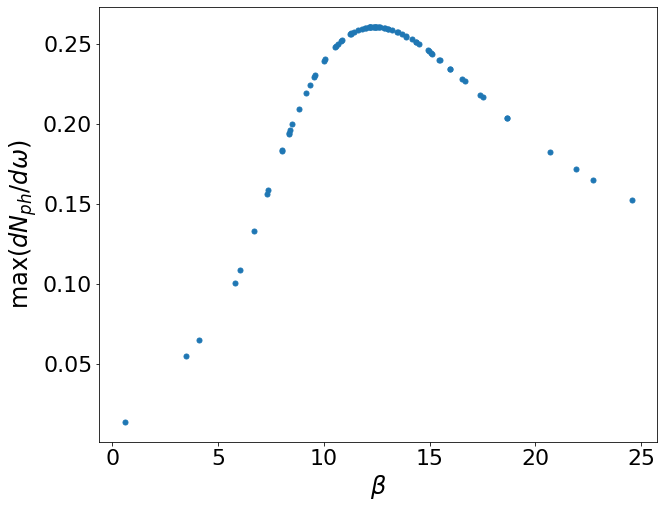

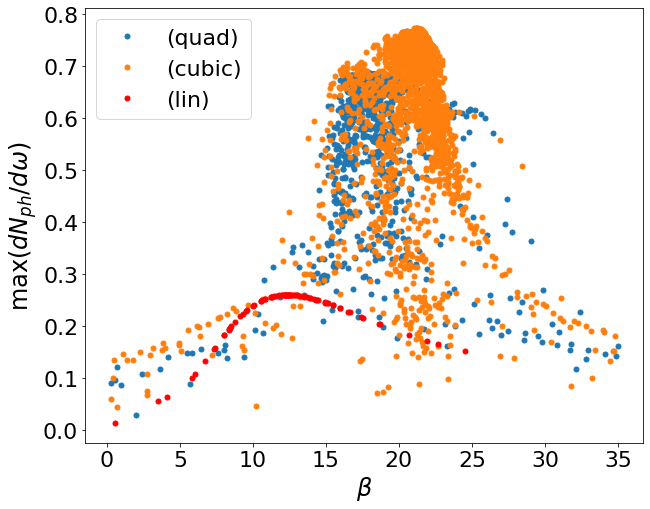

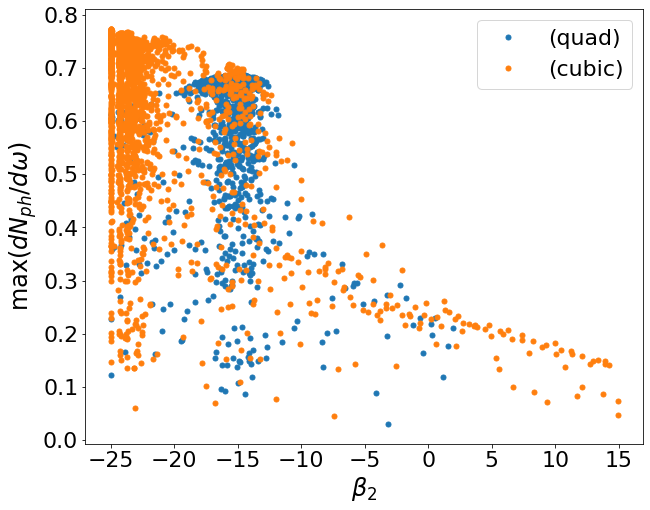

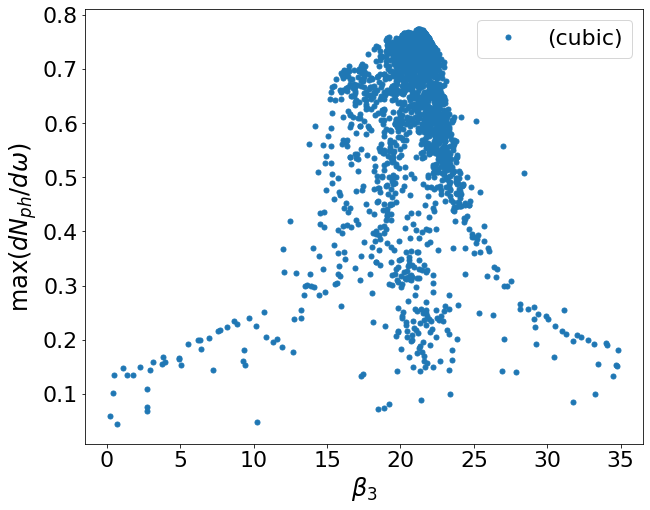

In [242]:
%matplotlib inline

# Plot optimization history
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(beta_arr_optuna, N_ph_lin_arr_optuna, '.', markersize=10, label='optuna trials')
# plt.legend(loc='lower right', fontsize=22)
plt.xlabel('$\\beta$', fontsize=24)
plt.ylabel('max($d N_{ph}/d\omega$)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(beta1_arr_optuna, N_ph_quad_arr_optuna, '.', markersize=10, label='(quad)')
plt.plot(beta1_arr_optuna_c, N_ph_quad_arr_optuna_c, '.', markersize=10, label='(cubic)')
plt.plot(beta_arr_optuna, N_ph_lin_arr_optuna, '.', color='red', markersize=10, label='(lin)')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$\\beta$', fontsize=24)
plt.ylabel('max($d N_{ph}/d\omega$)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(beta2_arr_optuna, N_ph_quad_arr_optuna, '.', markersize=10, label='(quad)')
plt.plot(beta2_arr_optuna_c, N_ph_quad_arr_optuna_c, '.', markersize=10, label='(cubic)')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$\\beta_2$', fontsize=24)
plt.ylabel('max($d N_{ph}/d\omega$)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(beta3_arr_optuna_c, N_ph_quad_arr_optuna_c, '.', markersize=10, label='(cubic)')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$\\beta_3$', fontsize=24)
plt.ylabel('max($d N_{ph}/d\omega$)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [219]:
study_quad.best_value

0.6877452449458854

<IPython.core.display.Javascript object>


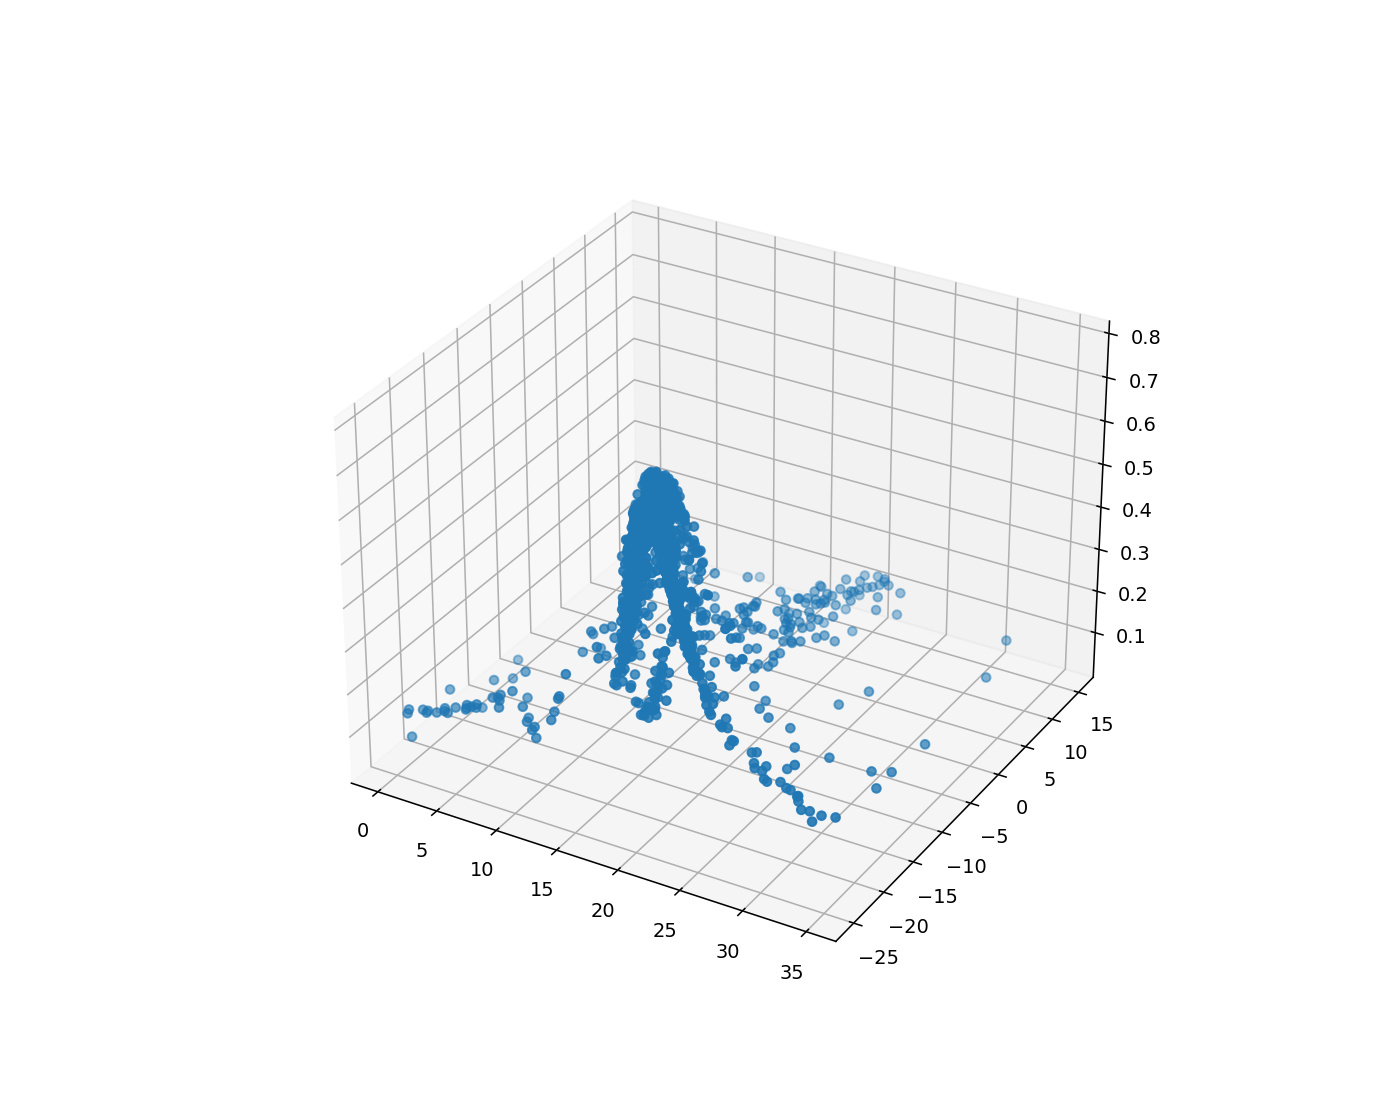

In [11]:
%matplotlib notebook

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(beta1_arr_optuna_c,
           beta2_arr_optuna_c,
           N_ph_arr_optuna_c)
plt.show()

<IPython.core.display.Javascript object>


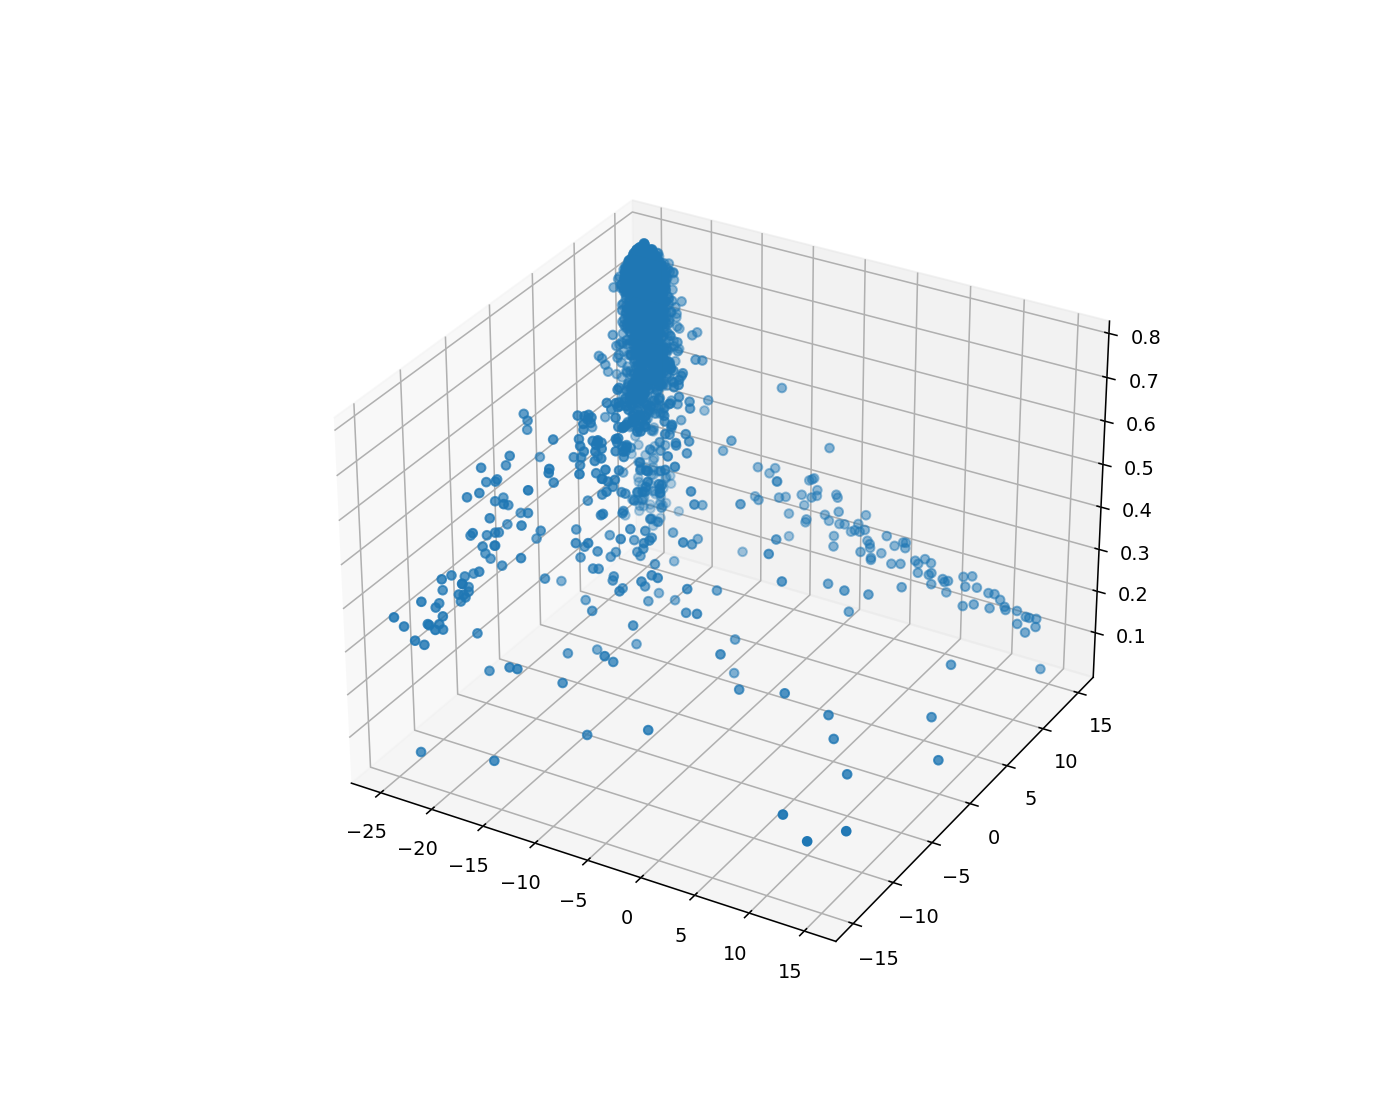

In [12]:
%matplotlib notebook

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(beta2_arr_optuna_c,
           beta3_arr_optuna_c,
           N_ph_arr_optuna_c)
plt.show()

<IPython.core.display.Javascript object>


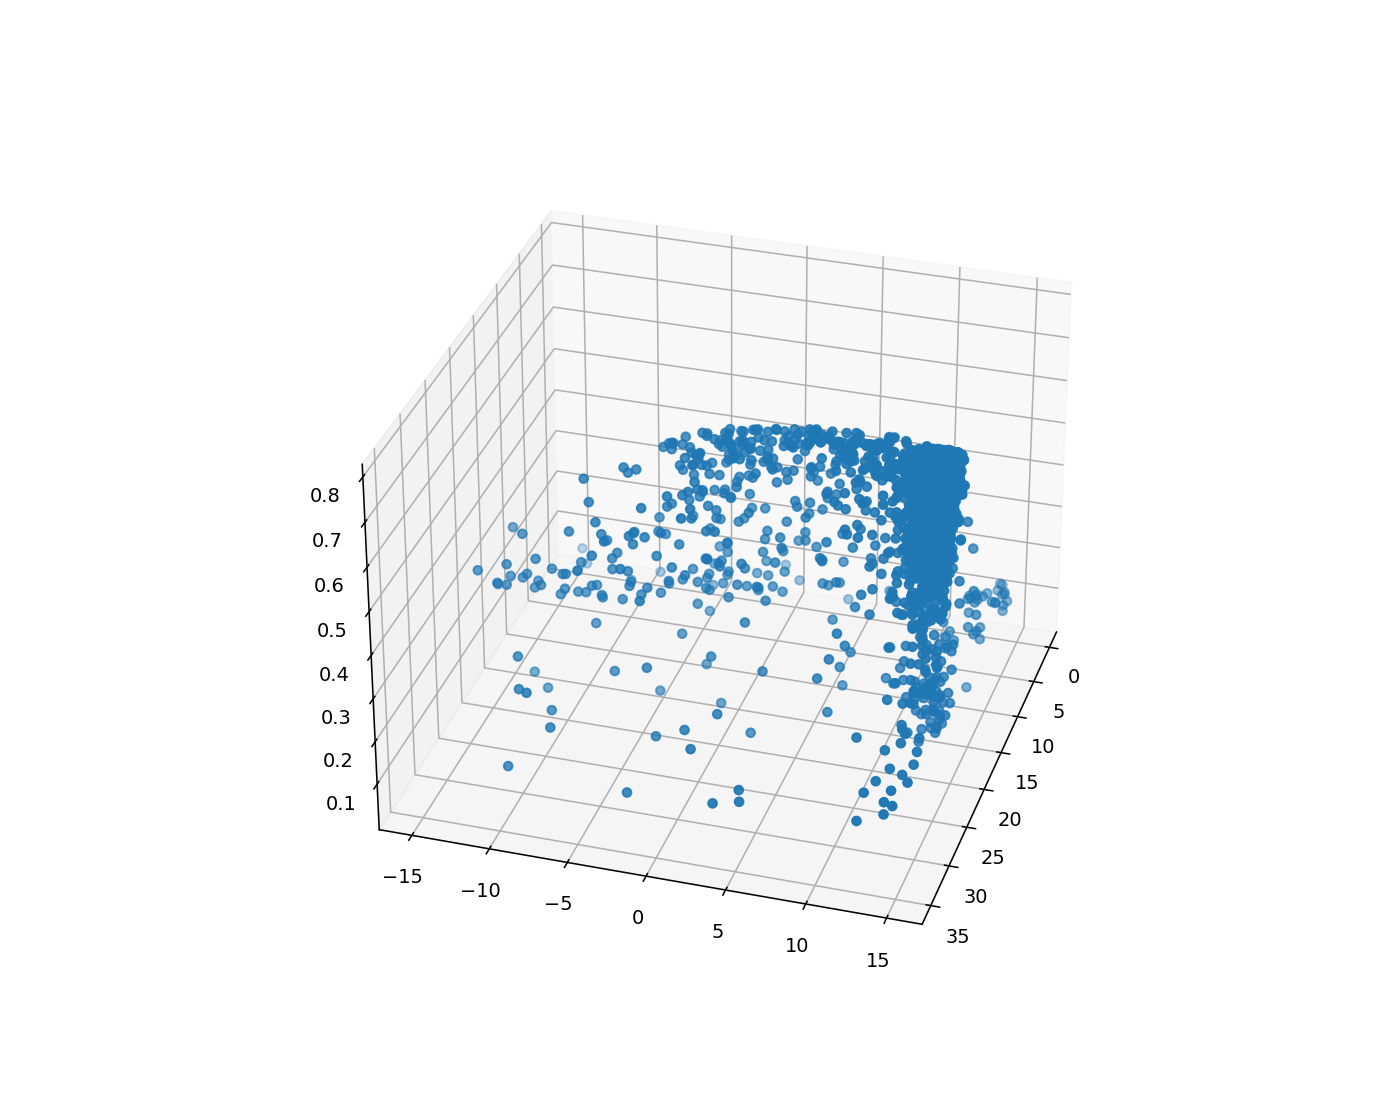

In [13]:
%matplotlib notebook

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(beta1_arr_optuna_c,
           beta3_arr_optuna_c,
           N_ph_arr_optuna_c)
plt.show()